**Amazon Sales - Clustering only**

**Dataset: https://www.kaggle.com/datasets/karkavelrajaj/amazon-sales-dataset**

**-------------------------------------------------------------**

**Short description:**

**This dataset contains around 1.4k Amazon products with metadata and user reviews.**

**Each row represents one product and includes pricing, discount, category hierarchy,**

**ratings, and textual information (product name, description, reviews).**

**Example columns: 'product_id', 'product_name', 'category', 'discounted_price',**

**'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product'.**

**The 'category' column is hierarchical (e.g. "Electronics|Headphones|In-Ear").**

**-------------------------------------------------------------**

**Problem definition:**

**Clustering problem: we want to group similar products automatically using both numeric**

**and textual features. This can reveal groups such as high-end electronics, low-price**

**accessories, etc. It has practical value for recommendation, pricing strategy, and**

**marketing segmentation.**

**-------------------------------------------------------------**


In [354]:


import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (download from Kaggle first)
df = pd.read_csv('amazon.csv')

# Drop irrelevant columns if they exist
df.drop(columns=['product_id', 'user_id', 'user_name', 'review_id', 'img_link', 'product_link'], inplace=True, errors='ignore')

print('Loaded dataset with shape:', df.shape)

# Display first rows
print('\nFirst rows of the dataset:')
print(df.iloc[0])

Loaded dataset with shape: (1465, 10)

First rows of the dataset:
product_name           Wayona Nylon Braided USB to Lightning Fast Cha...
category               Computers&Accessories|Accessories&Peripherals|...
discounted_price                                                    ₹399
actual_price                                                      ₹1,099
discount_percentage                                                  64%
rating                                                               4.2
rating_count                                                      24,269
about_product          High Compatibility : Compatible With iPhone 12...
review_title           Satisfied,Charging is really fast,Value for mo...
review_content         Looks durable Charging is fine tooNo complains...
Name: 0, dtype: object


**Conversion des colonnes numériques (parse prix etc.)**

In [355]:
def to_float_price(x):
    if pd.isna(x):
        return np.nan
    s = re.sub(r"[^0-9.\-]", "", str(x))
    try:
        return float(s)
    except:
        return np.nan

for col in ['discounted_price','actual_price','discount_percentage','rating','rating_count']:
    if col in df.columns:
        df[col] = df[col].apply(to_float_price)


print('\nData types after conversion:')
print(df.iloc[0])


Data types after conversion:
product_name           Wayona Nylon Braided USB to Lightning Fast Cha...
category               Computers&Accessories|Accessories&Peripherals|...
discounted_price                                                   399.0
actual_price                                                      1099.0
discount_percentage                                                 64.0
rating                                                               4.2
rating_count                                                     24269.0
about_product          High Compatibility : Compatible With iPhone 12...
review_title           Satisfied,Charging is really fast,Value for mo...
review_content         Looks durable Charging is fine tooNo complains...
Name: 0, dtype: object


**CLEAN DATA**

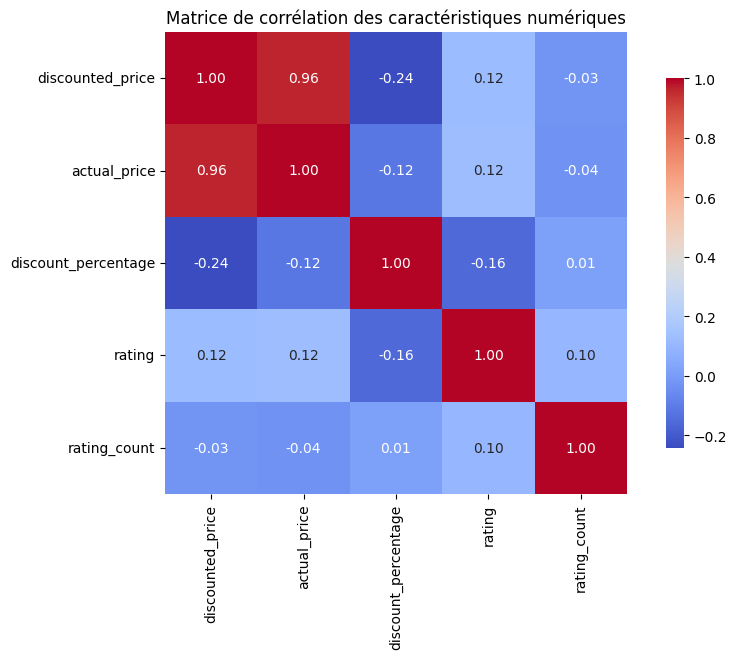

In [356]:
# Sélection des colonnes numériques
num_cols = ['discounted_price','actual_price','discount_percentage','rating','rating_count']

# Remplissage des valeurs manquantes (ex : mediane)
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Matrice de corrélation
corr = df[num_cols].corr()

# Affichage de la matrice de corrélation
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8}, square=True)
plt.title('Matrice de corrélation des caractéristiques numériques')
plt.show()

In [357]:
df.drop(columns=['discounted_price'], inplace=True, errors='ignore')
if 'discounted_price' in num_cols:
    num_cols.remove('discounted_price')

def extract_top_category(cat):
    try:
        if pd.isna(cat):
            return 'Unknown'
        return str(cat).split('|')[2].strip()
    except:
        return 'Unknown'

df['category_1'] = df['category'].apply(extract_top_category)
df.drop(columns=['category'], inplace=True, errors='ignore')
print(df['category_1'].value_counts())

# Traitement des descriptions textuelles
potential_text_cols = ['product_name','category_1','about_product','review_title','review_content']
text_col = [c for c in potential_text_cols if c in df.columns]

category_1
Cables&Accessories           240
SmallKitchenAppliances       181
Accessories                   97
MobileAccessories             84
Vacuum,Cleaning&Ironing       82
                            ... 
Memory                         1
ExternalMemoryCardReaders      1
VideoCameras                   1
Flashes                        1
Parts&Accessories              1
Name: count, Length: 72, dtype: int64


**TEXT VECTORIZATION (TF-IDF + SVD)**

In [358]:
df['full_text'] = df[text_col].fillna('').agg(' '.join, axis=1)

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_text = vectorizer.fit_transform(df['full_text'])

# Réduction de dimensionnalité avec SVD
svd = TruncatedSVD(n_components=50, random_state=42)
X_text_reduced = svd.fit_transform(X_text)

# Standardisation des caractéristiques numériques
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(df[num_cols])

X = np.hstack([X_num_scaled, X_text_reduced])

**CLUSTERING**


Optimizing KMeans for k=2..15...
k=2: silhouette=0.2387, CH=336.58, DB=1.75
k=3: silhouette=0.2350, CH=356.48, DB=1.42
k=4: silhouette=0.2539, CH=448.33, DB=1.13
k=5: silhouette=0.2628, CH=400.54, DB=1.07
k=6: silhouette=0.2732, CH=473.24, DB=1.00
k=7: silhouette=0.2253, CH=453.71, DB=1.14
k=8: silhouette=0.2056, CH=398.67, DB=1.17
k=9: silhouette=0.2185, CH=403.88, DB=1.12
k=10: silhouette=0.2325, CH=429.22, DB=1.07
k=11: silhouette=0.2101, CH=416.33, DB=1.12
k=12: silhouette=0.2133, CH=393.87, DB=1.12
k=13: silhouette=0.2036, CH=383.86, DB=1.15
k=14: silhouette=0.1994, CH=379.31, DB=1.17
k=15: silhouette=0.1970, CH=367.36, DB=1.20


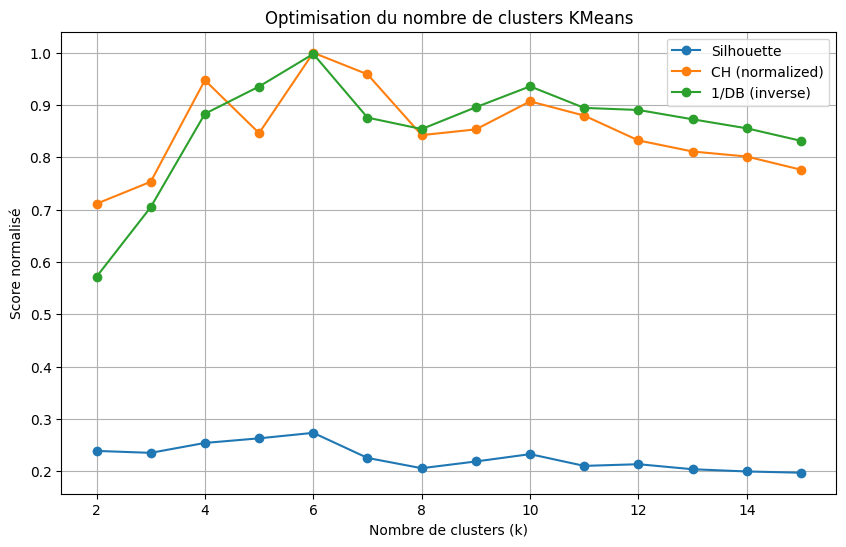


Best k selected (multi-metric): 6

Cluster sizes:
cluster
1    581
0    439
5    271
2     82
3     78
4     14
Name: count, dtype: int64


In [359]:
print('\nOptimizing KMeans for k=2..15...')

results = {'k': [], 'silhouette': [], 'CH': [], 'DB': []}

# Test d’un éventail large de k
for k in range(2, 16):
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init='auto',      # Scikit-learn 1.4+ optimise automatiquement le nombre d’initialisations
        init='k-means++',   # Initialisation intelligente
        max_iter=600,       # Plus d’itérations possibles pour meilleure convergence
        tol=1e-4            # Tolérance plus fine
    )
    labels = km.fit_predict(X)

    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    results['k'].append(k)
    results['silhouette'].append(sil)
    results['CH'].append(ch)
    results['DB'].append(db)
    print(f"k={k}: silhouette={sil:.4f}, CH={ch:.2f}, DB={db:.2f}")

# Conversion en DataFrame pour visualiser
results_df = pd.DataFrame(results)

# Visualisation des métriques pour choisir k
plt.figure(figsize=(10,6))
plt.plot(results_df['k'], results_df['silhouette'], 'o-', label='Silhouette')
plt.plot(results_df['k'], results_df['CH'] / results_df['CH'].max(), 'o-', label='CH (normalized)')
plt.plot(results_df['k'], 1 / results_df['DB'], 'o-', label='1/DB (inverse)')
plt.title("Optimisation du nombre de clusters KMeans")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Score normalisé")
plt.legend()
plt.grid(True)
plt.show()

# Sélection du meilleur k avec moyenne pondérée
# (met plus de poids à la silhouette et CH, car DB est inverse)
scores_combined = (
    0.5 * np.array(results_df['silhouette']) +
    0.4 * (results_df['CH'] / results_df['CH'].max()) +
    0.1 * (1 / results_df['DB'])
)
best_k = results_df.loc[np.argmax(scores_combined), 'k']
print(f"\nBest k selected (multi-metric): {best_k}")

# Réentraîner le modèle final avec ce k
km_final = KMeans(n_clusters=int(best_k), random_state=42, n_init='auto', max_iter=600)
labels = km_final.fit_predict(X)
df['cluster'] = labels

print('\nCluster sizes:')
print(df['cluster'].value_counts())


**Visualisation**

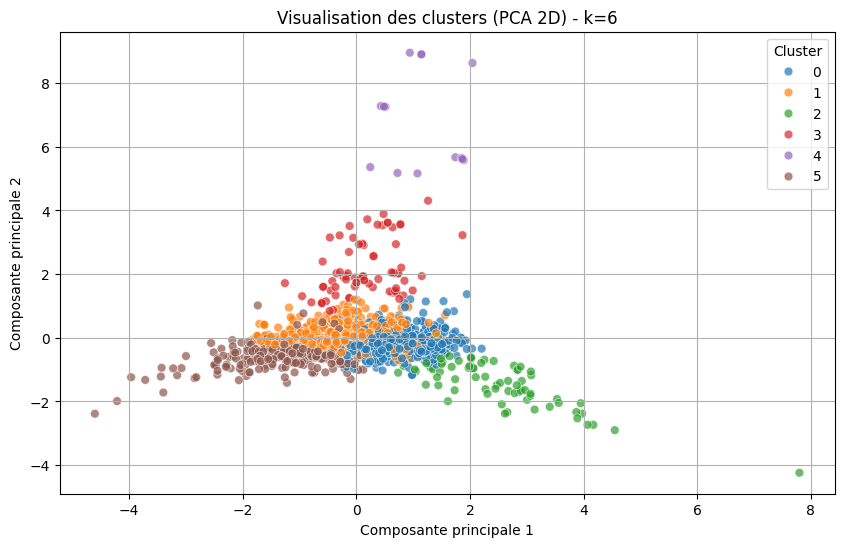

In [360]:
# --- PCA visualization of clusters ---
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster'], palette='tab10', s=40, alpha=0.7)
plt.title(f'Visualisation des clusters (PCA 2D) - k={int(best_k)}')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

**Analyse des moyennes numériques**


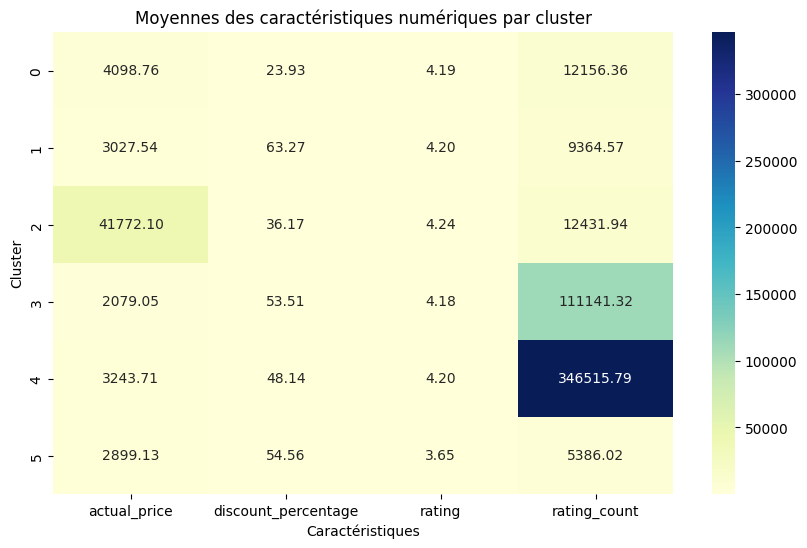


Moyennes numériques par cluster :
         actual_price  discount_percentage  rating  rating_count
cluster                                                         
0             4098.76                23.93    4.19      12156.36
1             3027.54                63.27    4.20       9364.57
2            41772.10                36.17    4.24      12431.94
3             2079.05                53.51    4.18     111141.32
4             3243.71                48.14    4.20     346515.79
5             2899.13                54.56    3.65       5386.02

Top 3 catégories par cluster :
                          level_1  count
cluster                                 
0          SmallKitchenAppliances     80
0        Smartphones&BasicMobiles     48
0         Vacuum,Cleaning&Ironing     37
1              Cables&Accessories    174
1               MobileAccessories     56
1                    SmartWatches     51
2                     Televisions     51
2        Smartphones&BasicMobiles     18
2  

In [361]:
cluster_means = df.groupby('cluster')[num_cols].mean().round(2)

plt.figure(figsize=(10,6))
sns.heatmap(
    cluster_means, annot=True, fmt=".2f", cmap='YlGnBu',
    cbar_kws={'format': '%.0f'}
)
plt.title("Moyennes des caractéristiques numériques par cluster")
plt.xlabel("Caractéristiques")
plt.ylabel("Cluster")
plt.show()

print("\nMoyennes numériques par cluster :")
print(cluster_means)

# --- Catégories dominantes ---
top_categories = (
    df.groupby('cluster')['category_1']
    .apply(lambda x: x.value_counts().head(3))
    .reset_index(level=1, name='count')
)

print("\nTop 3 catégories par cluster :")
print(top_categories)

**Conclusion**

Le meilleur clustering KMeans a identifié 6 groupes selon le prix, la remise, la note et le nombre d’avis.

Clusters clés après analyse:

Cluster 0 : produits haut de gamme avec faible remise.

Cluster 1 : produits fortement remisés (bons plans) contenant majoritairement des accesoires et des montres intelligentes (surment le bon d'en acheter).

Cluster 2 : produits très chers, premium avec faible remise car d'une grande importance au quotidien comme la télé ou le téléphone.

Cluster 3 : produits populaires avec beaucoup d’avis qui accompagne surment les produit phares.

Cluster 4 : produits phares et best-sellers.

Cluster 5 : produits moyens ou peu visibles, notes plus faibles essayant d'être vendu via de haute reduction.

Cette segmentation permet de comprendre rapidement le positionnement des produits et d’identifier les opportunités de promotion ou de mise en avant.